# Детектирование объектов

В данной лекции мы с вами разберем пример детектирования объектов с использованием сверточных сетей на основе фреймворка TensorFlow. Данный ноутбук распространяется вместе с набором данных SampleDataset.tfds, который должен находиться в той же папке, что и ноутбук.

Проверим, что необходимые пакеты установлены.

In [ ]:
!pip install numpy tensorflow matplotlib seaborn pandas

ERROR: Could not find a version that satisfies the requirement tensorflow (from versions: none)
ERROR: No matching distribution found for tensorflow


Импортируем необходимые пакеты.

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.patches as mpatches

Изменим размеры выводимых изображений.

In [ ]:
plt.rcParams['figure.figsize'] = [18, 5]

Загрузим набор данных и выведем количество объектов в нем. Данный набор подготовлен на основе следующего набора данных: https://www.kaggle.com/kishanj/simple-object-detection

In [ ]:
dataset = tf.data.experimental.load(
    'SampleDataset.tfds',
    element_spec=(tf.TensorSpec(shape=(None, None, 3), dtype=tf.float64, name=None),
                 (tf.TensorSpec(shape=(), dtype=tf.int64, name=None),
                  tf.TensorSpec(shape=(), dtype=tf.int64, name=None),
                  tf.TensorSpec(shape=(), dtype=tf.int64, name=None),
                  tf.TensorSpec(shape=(), dtype=tf.int64, name=None)))
)
len(dataset)

Metal device set to: Apple M1 Pro


2022-11-15 18:27:34.236582: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-15 18:27:34.236734: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


112

Далее разделим набор данных на тренировочный и тестовый наборы.

In [ ]:
dataset = dataset.shuffle(len(dataset))
split = int(len(dataset) * 0.8)

train_dataset = dataset.take(split).batch(1)
test_dataset = dataset.skip(split).take(len(dataset) - split).batch(1)

Формат данного датасета следующий:
* Первым объектом кортежа идет 3-х канальное изображение объекта
* Следующим объектом кортежа является кортеж из 4-х значений, где первые два — это координаты $x$ и $y$ левого верхнего угла, а вторые два значения — координаты $x$ и $y$ правого нижнего угла соответствующего bounding box'а.

Выведем изображения и наложим поверх них прямоугольник с указанными координатами.

2022-11-15 18:27:34.344650: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


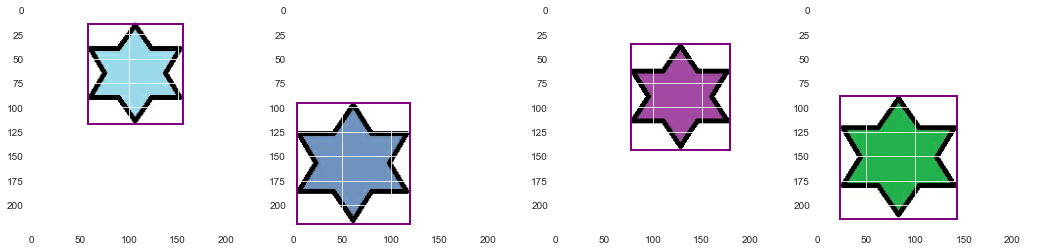

In [ ]:
f, axarr = plt.subplots(1, 4)

for i, pair in enumerate(test_dataset.take(4)):
    img, bbox = pair
    axarr[i].imshow(img.numpy().reshape(224, 224, 3))
    w = bbox[2] - bbox[0]
    h = bbox[3] - bbox[1]
    rect=mpatches.Rectangle((bbox[0], bbox[1]), w, h, fill=False, color="purple", linewidth=2)
    axarr[i].add_patch(rect)

В данном случае на каждом изображении находится только один объект, который нужно поместить в наиболее экономный bounding box. Значит, мы можем создать сеть, у которой будет 4 головы, соответствующие 4 выходам сети с линейной активацией. Выходы будут предсказывать координаты, соответствующие левому верхнему и правому нижнему углам.

Ради эксперимента давайте реализуем сверточную модель с использованием только сверточных слоев.

В первую очередь сеть должна иметь несколько сверточных слоев, которые будут заниматься выделением важных признаков изображени. В конце блока сверточных слоев поставим технический слой для преобразования выхода к входу полносвязных слоев.

In [ ]:
# Model Setup
x0 = tf.keras.Input(shape=(224,224,3))
x = tf.keras.layers.Conv2D(filters=128, kernel_size=(5, 5), strides=(2, 2), activation=tf.nn.relu)(x0)
x = tf.keras.layers.Conv2D(filters=128, kernel_size=(5, 5), strides=(2, 2), activation=tf.nn.relu)(x)
x = tf.keras.layers.Conv2D(filters=64, kernel_size=(5, 5), strides=(2, 2), activation=tf.nn.relu)(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation=tf.nn.relu)(x)
x = tf.keras.layers.Conv2D(filters=16, kernel_size=(5, 5), activation=tf.nn.relu)(x)
x = tf.keras.layers.Flatten()(x)

Далее добавим полносвязный слой для обработки выхода с сверточных слоев, а затем создадим «головы» - блоки для предсказания соответствующей координаты.

In [ ]:
x = tf.keras.layers.Dense(256, activation=tf.nn.relu)(x)

x1 = tf.keras.layers.Dense(64, activation=tf.nn.relu)(x)
y1 = tf.keras.layers.Dense(1, activation="linear", name="y1")(x1)

x2 = tf.keras.layers.Dense(64, activation=tf.nn.relu)(x)
y2 = tf.keras.layers.Dense(1, activation="linear", name="y2")(x2)

x3 = tf.keras.layers.Dense(64, activation=tf.nn.relu)(x)
y3 = tf.keras.layers.Dense(1, activation="linear", name="y3")(x3)

x4 = tf.keras.layers.Dense(64, activation=tf.nn.relu)(x)
y4 = tf.keras.layers.Dense(1, activation="linear", name="y4")(x4)

Не забудем корректно собрать модель, указав вход и выходы, а также скомпилируем с использованием оптимизатора Adam и функции потерь MSE для каждой из 4-х «голов».

In [ ]:
model = tf.keras.Model(inputs=x0, outputs=[y1, y2, y3, y4])
model.compile(tf.keras.optimizers.Adam(learning_rate=0.001), loss=['mse', 'mse', 'mse', 'mse'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 110, 110, 12  9728        ['input_1[0][0]']                
                                8)                                                                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 53, 53, 128)  409728      ['conv2d[0][0]']                 
                                                                                              

Давайте запустим тренировку нашей модели.

In [ ]:
history = model.fit(train_dataset, epochs=30, validation_data=test_dataset)

Epoch 1/30


2022-11-15 18:27:36.372627: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


87/89 [============================>.] - ETA: 0s - loss: 18979.5566 - y1_loss: 2208.6201 - y2_loss: 3289.4573 - y3_loss: 6089.0962 - y4_loss: 7392.3794

2022-11-15 18:27:42.381445: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


89/89 [==============================] - 7s 31ms/step - loss: 18707.1758 - y1_loss: 2192.8772 - y2_loss: 3228.9358 - y3_loss: 6022.6548 - y4_loss: 7262.7046 - val_loss: 9388.3428 - val_y1_loss: 1442.6787 - val_y2_loss: 2336.9788 - val_y3_loss: 1853.7739 - val_y4_loss: 3754.9106
Epoch 2/30
89/89 [==============================] - 3s 28ms/step - loss: 11373.3994 - y1_loss: 1860.9730 - y2_loss: 2211.7529 - y3_loss: 3988.1843 - y4_loss: 3312.4880 - val_loss: 15884.9961 - val_y1_loss: 879.9395 - val_y2_loss: 5713.8276 - val_y3_loss: 2126.5046 - val_y4_loss: 7164.7241
Epoch 3/30
89/89 [==============================] - 3s 28ms/step - loss: 8003.5532 - y1_loss: 1509.4193 - y2_loss: 2240.2778 - y3_loss: 2227.8135 - y4_loss: 2026.0415 - val_loss: 5991.5781 - val_y1_loss: 1425.6359 - val_y2_loss: 1808.2611 - val_y3_loss: 1304.9088 - val_y4_loss: 1452.7726
Epoch 4/30
89/89 [==============================] - 3s 27ms/step - loss: 11890.3008 - y1_loss: 1873.0576 - y2_loss: 2262.1616 - y3_loss: 4148.

Визуализируем историю обучения модели.

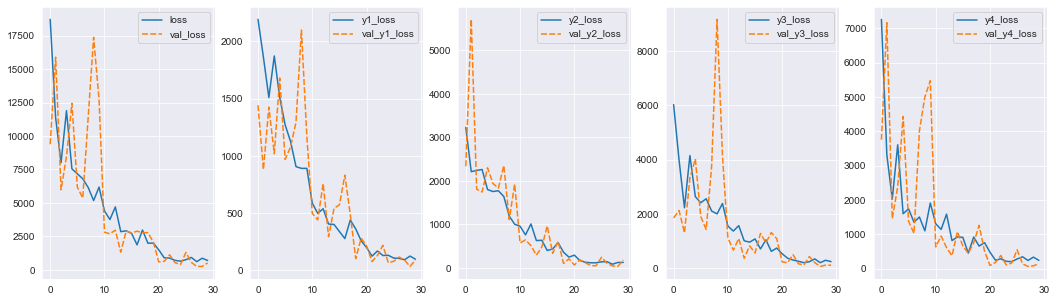

In [ ]:
df = pd.DataFrame(history.history)

f, axes = plt.subplots(1, 5)

ax = sns.lineplot(data=df[['loss', 'val_loss']], ax=axes[0])
for i in range(1, 5):
    ax = sns.lineplot(data=df[[f'y{i}_loss', f'val_y{i}_loss']], ax=axes[i])

Для визуальной проверки давайте получим предсказания модели на тестовом наборе данных.

In [ ]:
predictions = model.predict(test_dataset)

2022-11-15 18:28:58.620101: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


23/23 [==============================] - 0s 6ms/step


Теперь визуализируем несколько изображений, наложив на них настоящую маску и предсказанную.

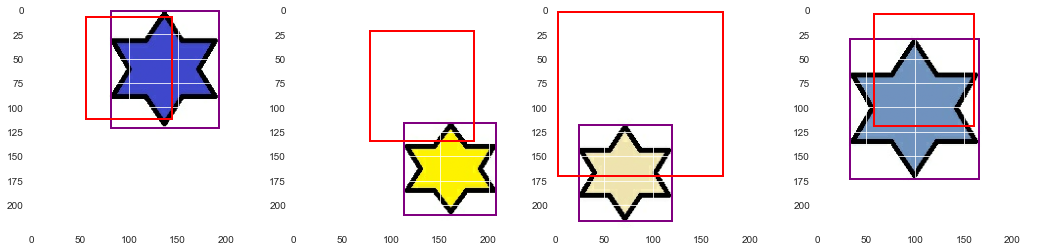

In [ ]:
f, axarr = plt.subplots(1, 4)

for i, pair in enumerate(test_dataset.take(4)):
    img, bbox = pair
    axarr[i].imshow(img.numpy().reshape(224, 224, 3))
    
    # ground truth
    w = bbox[2] - bbox[0]
    h = bbox[3] - bbox[1]
    rect=mpatches.Rectangle((bbox[0], bbox[1]), w, h, fill=False, color="purple", linewidth=2)
    axarr[i].add_patch(rect)
    
    # prediction
    w = predictions[2][i] - predictions[0][i]
    h = predictions[3][i] - predictions[1][i]
    rect=mpatches.Rectangle((predictions[0][i], predictions[1][i]), w, h, fill=False, color="red", linewidth=2)
    axarr[i].add_patch(rect)

Далее мы предлагаем вам посмотреть на результаты и оценить, насколько вам нравится то, что получилось. Можете ли вы сделать лучше? Рекомендуем поэкспериментировать с различными гиперпараметрами модели, такими как коэффициент скорости обучения, количество эпох, количество фильтров в слоях, функции активации, и т.д.

Удачи!